In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import networkx as nx


/Users/harman/.pyenv/versions/3.7.9/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [14]:
comments_df = pd.read_csv('new_box/comments/comments_2021-08.csv')  
submissions_df = pd.read_csv('reddit/submissions/RS_2021-08-new.csv')  


In [15]:
power_terms = [
    "Blackout", "power", "power grid", "power outage", "power out", "electricity", 
    "electric", "brownout", "voltage", "transformer", "circuit breaker", 
    "electrical outage", "energy storage", "transmission line", "renewable energy", 
    "smart grid", "energy efficiency", "peak demand", "alternative energy", 
    "solar power", "wind energy", "hydropower", "generator", "backup generator", 
    "utilities", "electric utility", "grid", "grid stability", "surge protector", 
    "energy", "microgrid", "off-grid", "rolling blackout", "energy policy", "grid operator", "electric current", "power grid", "power plant", "breaker", "current",
    "distribution", "substation", "energy grid", "load shedding", "frequency regulation", "demand response", "battery storage", "turbine", 
    "nuclear energy", "fossil fuels", "bioenergy", "geothermal", "load center", "interconnector", "distributed generation", "demand-side management", 
    "capacity factor", "net metering", "kilowatt-hour", "megawatt", "outage", "grid failure", "electrical fault", "cable fault", "energy consumption", 
    "load balancing", "grid expansion", "power line", "overload", "switchgear", "resilience", "reliability", "power factor", "feed-in tariff", 
    "baseline load", "peaker plant", "inverter", "grid-tied", "islanding", "energy mix"
]
pattern = '|'.join(power_terms).lower()

In [53]:
with open('images/power_terms.txt', 'w') as f:
    for item in power_terms:
        f.write("%s\n" % item)

In [16]:
def filter_by_power_terms(df, text_columns):
    combined_text = df[text_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1).str.lower()
    return df[combined_text.str.contains(pattern)]

In [17]:
comments_df['link_id'] = comments_df['link_id'].str.replace('t3_', '')


In [19]:
merged_data = pd.merge(comments_df, submissions_df, left_on='link_id', right_on='id', suffixes=('_comment', '_submission'))

In [21]:
filtered_data = filter_by_power_terms(merged_data, ['body', 'title', 'selftext'])


In [22]:
active_subreddits = filtered_data['subreddit_submission'].value_counts()
print("Active subreddits in power-related discussions:")
print(active_subreddits)

Active subreddits in power-related discussions:
NewOrleans          10471
Austin               7323
texas                5647
houston              2538
newjersey            2124
nyc                  2063
longisland           1265
sanantonio            888
batonrouge            772
Buffalo               728
jerseycity            613
Acadiana              435
Louisiana             410
Brooklyn              355
Denton                186
Westchester           163
newyork               123
Hoboken               115
SouthJersey           111
corpus                 78
Pflugerville           78
williamsburg           64
hudsonvalley           45
Newark                 38
galveston              37
Adirondacks            30
Queens                 30
AsburyPark             29
houma                  28
CorpusChristi          18
Bushwick               15
CentralLouisiana       10
parkslope               8
NOLA                    8
NewBrunswickNJ          2
ForestHills             1
bronx           

In [48]:
active_subreddits.to_csv('power_discussion_subreddits.csv')

In [27]:
active_subreddits = filtered_data['subreddit_submission'].value_counts()

df = active_subreddits.reset_index()
df.columns = ['Subreddit', 'Number of Discussions']

fig = px.bar(df, x='Subreddit', y='Number of Discussions',
             hover_data=['Subreddit', 'Number of Discussions'], color='Number of Discussions',
             labels={'Number of Discussions':'Number of Power-Related Discussions'},
             title='Power-Related Discussions in Different Subreddits')
fig.show()

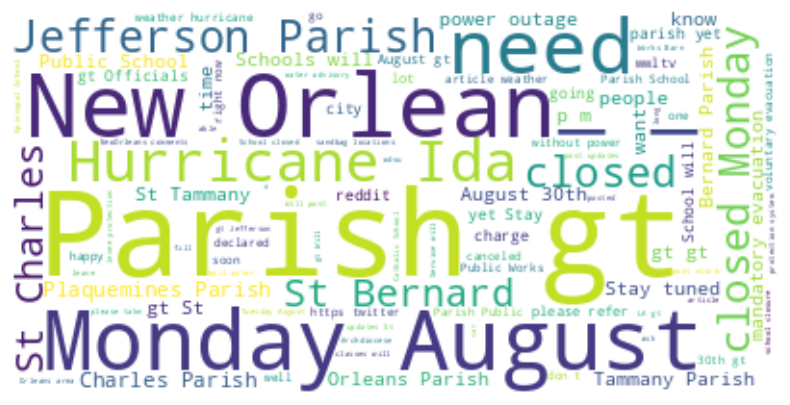

In [37]:
all_text = ' '.join(filtered_data['body'].astype(str) + ' ' +
                    filtered_data['title'].astype(str) + ' ' +
                    filtered_data['selftext'].astype(str))

wordcloud = WordCloud(background_color='white', max_words=100, contour_color='steelblue').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [40]:
active_subreddits_df = active_subreddits.reset_index()
active_subreddits_df.columns = ['Subreddit', 'Discussions']

# Create the tree map
fig = px.treemap(active_subreddits_df, path=['Subreddit'], values='Discussions',
                 title='Tree Map of Power-Related Discussions in Subreddits')
fig.show()


In [42]:
fig.write_html("power-related-discussions.html")

In [41]:
def count_terms(df, terms):
    term_counts = {term: df['text'].str.contains(term, case=False, na=False).sum() for term in terms}
    return pd.Series(term_counts)

filtered_data['text'] = filtered_data['title'].fillna('') + ' ' + filtered_data['selftext'].fillna('') + ' ' + filtered_data['body'].fillna('')
term_frequencies = filtered_data.groupby('subreddit_submission').apply(count_terms, terms=power_terms)
term_frequencies_df = term_frequencies.apply(pd.Series).reset_index()
term_frequencies_melted = term_frequencies_df.melt(id_vars=['subreddit_submission'], var_name='Term', value_name='Frequency')

fig = px.treemap(term_frequencies_melted, path=['subreddit_submission', 'Term'], values='Frequency',
                 title='Tree Map of Power-Related Term Frequencies in Subreddits')
fig.show()


/Users/harman/.pyenv/versions/3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
import re
def get_thread_info(df, term):
    relevant_threads = df[df['text'].str.contains(term, case=False, na=False)]
    relevant_threads['size'] = relevant_threads['text'].apply(lambda x: len(re.findall(term, x, re.IGNORECASE)))
    relevant_threads['label'] = relevant_threads['title'].str.slice(0, 30) + '...'  
    return relevant_threads[['label', 'size']].drop_duplicates()

thread_info = pd.DataFrame()
for term in power_terms:
    temp_df = filtered_data.groupby('subreddit_submission').apply(lambda df: get_thread_info(df, term))
    temp_df['Term'] = term
    temp_df = temp_df.reset_index().rename(columns={'level_1': 'Thread ID'})
    thread_info = thread_info.append(temp_df[['subreddit_submission', 'Term', 'label', 'size']], ignore_index=True)

fig = px.treemap(thread_info, path=['subreddit_submission', 'Term', 'label'], values='size',
                 title='Tree Map of Threads Containing Power-Related Terms in Subreddits')
fig.show()

In [52]:
fig.write_html("power-related-terms-deep-1.html")

In [60]:
merged_data.head()

,id_comment,author_comment,body,link_id,parent_id,subreddit_comment,subreddit_id,name,created_utc_comment,id_submission,author_submission,title,subreddit_submission,created_utc_submission,url,num_comments,score,selftext
0,h79c9hi,AutoModerator,YouTube submissions are automatically removed ...,ovi0tu,t3_ovi0tu,texas,t5_2qho4,t1_h79c9hi,1627776600,ovi0tu,[deleted],[deleted by user],texas,1627776600,https://www.reddit.com/r/texas/comments/ovi0tu...,1,1,[removed]
1,h79cgww,KnockemAllDown,None that I knew of yet. It probably won't ha...,ovhwg5,t3_ovhwg5,newjersey,t5_2qhsu,t1_h79cgww,1627776711,ovhwg5,TheGreyOne889,Vax Pass for restaurants?,newjersey,1627776135,https://www.reddit.com/r/newjersey/comments/ov...,40,1,Does anybody know if any of the restaurants in...
2,h79d9lp,[deleted],just get the fucking vaccine jesus christ,ovhwg5,t3_ovhwg5,newjersey,t5_2qhsu,t1_h79d9lp,1627777141,ovhwg5,TheGreyOne889,Vax Pass for restaurants?,newjersey,1627776135,https://www.reddit.com/r/newjersey/comments/ov...,40,1,Does anybody know if any of the restaurants in...
3,h79dzrb,TheGreyOne889,I already did. I want mandatory Vax pass,ovhwg5,t1_h79d9lp,newjersey,t5_2qhsu,t1_h79dzrb,1627777524,ovhwg5,TheGreyOne889,Vax Pass for restaurants?,newjersey,1627776135,https://www.reddit.com/r/newjersey/comments/ov...,40,1,Does anybody know if any of the restaurants in...
4,h79edii,[deleted],god bless man i was about to lose it 😂,ovhwg5,t1_h79dzrb,newjersey,t5_2qhsu,t1_h79edii,1627777728,ovhwg5,TheGreyOne889,Vax Pass for restaurants?,newjersey,1627776135,https://www.reddit.com/r/newjersey/comments/ov...,40,1,Does anybody know if any of the restaurants in...


In [61]:
# Filter for the NewOrleans and Austin subreddits
focused_subreddits = merged_data[(merged_data['subreddit_submission'] == 'NewOrleans') |
                                 (merged_data['subreddit_submission'] == 'Austin')]

focused_subreddits = filter_by_power_terms(focused_subreddits, ['body', 'title', 'selftext'])

discussion_counts = focused_subreddits['subreddit_submission'].value_counts()
authors_combined = pd.concat([
    focused_subreddits['author_comment'],
    focused_subreddits['author_submission']
]).drop_duplicates()

user_counts = focused_subreddits.groupby('subreddit_submission').apply(
    lambda x: pd.concat([
        x['author_comment'],
        x['author_submission']
    ]).nunique()
)

In [63]:
discussion_counts.head()

NewOrleans    10471
Austin         7323
Name: subreddit_submission, dtype: int64

In [57]:
# Taking a sample data for qualitative analysis
new_orleans_sample = focused_subreddits[focused_subreddits['subreddit_submission'] == 'NewOrleans'].sample(n=10)
austin_sample = focused_subreddits[focused_subreddits['subreddit_submission'] == 'Austin'].sample(n=10)

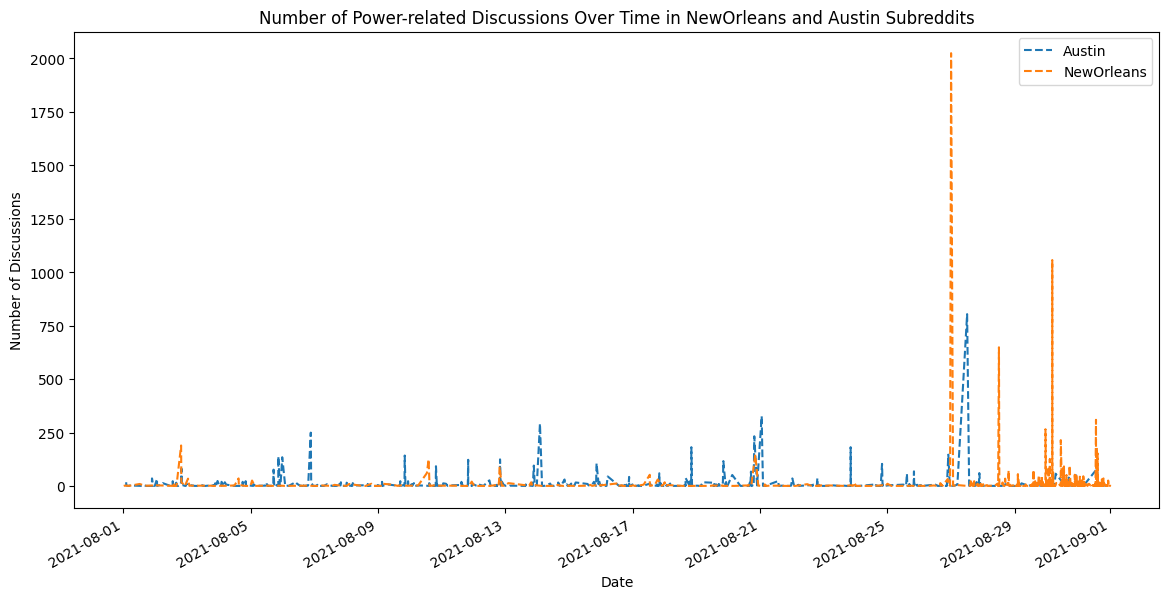

In [68]:
focused_subreddits['date_comment'] = pd.to_datetime(focused_subreddits['created_utc_comment'], unit='s')
focused_subreddits['date_submission'] = pd.to_datetime(focused_subreddits['created_utc_submission'], unit='s')

time_series_comments = focused_subreddits.groupby(['date_comment', 'subreddit_submission']).size()
time_series_submissions = focused_subreddits.groupby(['date_submission', 'subreddit_submission']).size()

plt.figure(figsize=(14, 7))

# Plotting comments
for subreddit, group in time_series_comments.groupby(level=1):
    group.unstack().plot(ax=plt.gca(), label=f"{subreddit} - Comments")

# Plotting submissions
for subreddit, group in time_series_submissions.groupby(level=1):
    group.unstack().plot(ax=plt.gca(), label=f"{subreddit} - Submissions", linestyle='--')

plt.title('Number of Power-related Discussions Over Time in NewOrleans and Austin Subreddits')
plt.xlabel('Date')
plt.ylabel('Number of Discussions')
plt.legend()
plt.show()

In [58]:
discussion_counts.head()

Austin        96332
NewOrleans    50548
Name: subreddit_submission, dtype: int64